# Fully Flexible Resampling (Vorobets 2025), Sacked Portfolio Risk Manager, and Regime Tilting (Tactical) Optimizer

## Fully Flexible Resampling
States variables: Growth (S&P500), VIX, Real Rates, Inflation.
The first two are high/mid/low, the rest are high/low partitioned.

In [3]:
#!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy alpaca-py seaborn yfinance fredapi

In [46]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
from fredapi import Fred
import fortitudo.tech as ft
import matplotlib.pyplot as plt
from datetime import datetime, date

from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.enums import DataFeed, Adjustment
ALPACA_API_KEY = 'PKY7Y1ONV9U2G5ZEQHDS'
ALPACA_SECRET_KEY = 'nA4m9QwFzSUTkhcHx1ZT0Y68Yq77e8sbCqYW8IFz'
fred = Fred(api_key='f887507374b463ac1fcc8e0ad01cbed3')
START_DATE = "2016-01-01"
today = date.today().isoformat()
fred = Fred(api_key='f887507374b463ac1fcc8e0ad01cbed3')

In [47]:
########### NEW DATA FETCHING CHUNK ########### 

In [48]:
ASSETS = [
    'NVDA', 'LLY', 'GS', 'DECK', 'COST', 'CAT', 
    'BTU', 'SHW', 'NRG', 'NFLX', 'CBRE'
]
COMMODITIES = ['GC=F', '^VIX', '^GSPC']

macro_df = yf.download(COMMODITIES, start=START_DATE, end="2026-01-31", auto_adjust=True)
if isinstance(macro_df.columns, pd.MultiIndex):
    macro_df = macro_df['Close']
else:
    macro_df = macro_df[['Close']].rename(columns={'Close': COMMODITIES[0]})
macro_df.index = pd.to_datetime(macro_df.index).date
macro_df.index.name = 'date'
macro_df.interpolate(method='linear', inplace=True)
stock_client = StockHistoricalDataClient(api_key=ALPACA_API_KEY, secret_key=ALPACA_SECRET_KEY)

CHUNK_SIZE = 100
all_bars_list = []
for i in range(0, len(ASSETS), CHUNK_SIZE):
    chunk = ASSETS[i:i + CHUNK_SIZE]
    print(f"Eating from {i} to {i + len(chunk)} Burgers makes me...")
    
    try:
        req = StockBarsRequest(
            symbol_or_symbols=chunk,
            timeframe=TimeFrame(1, TimeFrameUnit.Day),
            start=pd.to_datetime(START_DATE),
            end=pd.to_datetime(today),
            adjustment=Adjustment.ALL,
            feed=DataFeed.SIP
        )
        bars = stock_client.get_stock_bars(req)
        
        if not bars.df.empty:
            all_bars_list.append(bars.df)
            
    except Exception as e:
        print(f"Error eating them lol {chunk[0]}...: {e}")

if all_bars_list:
    stocks_data = pd.concat(all_bars_list)
else:
    raise ValueError("No burgers here moving to kfc")

stocks_data = stocks_data.reset_index()
stocks_data['date'] = stocks_data['timestamp'].dt.date
stocks_data = stocks_data.pivot_table(index='date', columns='symbol', values='close')

[*********************100%***********************]  3 of 3 completed


Eating from 0 to 11 Burgers makes me...


In [49]:
real_rate = fred.get_series('DFII10', START_DATE, today)
inflation = fred.get_series('T10YIE', START_DATE, today)

real_rate.index = pd.to_datetime(real_rate.index).date
inflation.index = pd.to_datetime(inflation.index).date

real_rate.rename('Real_Rate', inplace=True)
inflation.rename('Inflation', inplace=True)
real_rate.index.name = 'date'
inflation.index.name = 'date'

In [50]:
df = pd.merge(
    stocks_data, 
    macro_df, 
    left_on='date', 
    right_index=True, 
    how='left'
)
df.reset_index(inplace=True)
df['date'] = pd.to_datetime(df['date'])
data = df.set_index('date')

In [51]:
selected_assets = [col for col in data.columns if col not in ['^VIX', '^GSPC']]

data = data[[t for t in selected_assets if t in data.columns]]
data_clean = data.dropna(axis=0, how='any')

start_date = data_clean.index[0]
end_date = data_clean.index[-1]


state_vars = pd.DataFrame({
    'SP500': macro_df['^GSPC'],
    'VIX': macro_df['^VIX'],
    'RealRate': real_rate,
    'Inflation': inflation
}).reindex(data_clean.index).ffill().dropna()

state_vars['SP500_ret'] = np.log(state_vars['SP500'] / state_vars['SP500'].shift(1))
state_vars = state_vars.drop(columns='SP500').dropna()

common_dates = data_clean.index.intersection(state_vars.index)
asset_data = data_clean.loc[common_dates]
state_vars = state_vars.loc[common_dates]

pnl = np.log(asset_data / asset_data.shift(1)).dropna()
state_vars = state_vars.loc[pnl.index]

print(f"Assets: {asset_data.shape[1]} | Days: {len(pnl)}")
print(f"Range: {pnl.index[0].date()} → {pnl.index[-1].date()}")
print(f"{len(pnl)/252:.1f} years of data")

Assets: 12 | Days: 2532
Range: 2016-01-06 → 2026-01-30
10.0 years of data


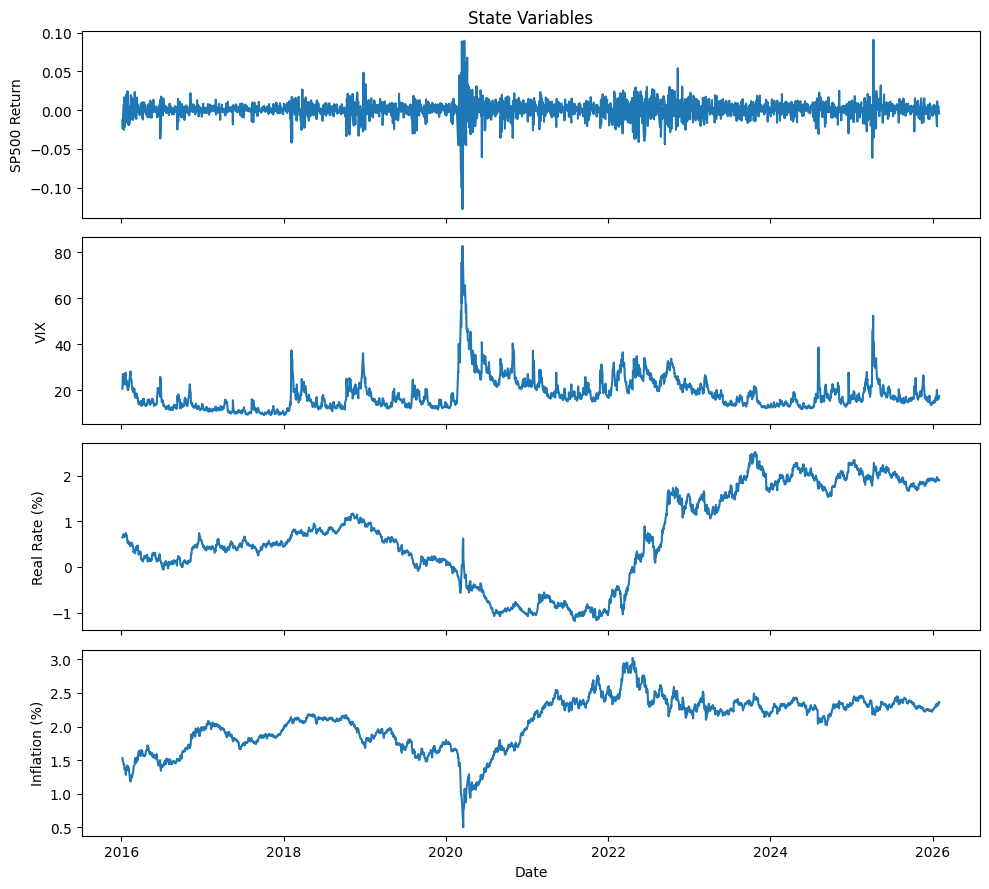

In [52]:
fig, axes = plt.subplots(4, 1, figsize=(10, 9), sharex=True)

axes[0].plot(state_vars['SP500_ret'])
axes[0].set_ylabel('SP500 Return')
axes[0].set_title('State Variables')

axes[1].plot(state_vars['VIX'])
axes[1].set_ylabel('VIX')

axes[2].plot(state_vars['RealRate'])
axes[2].set_ylabel('Real Rate (%)')

axes[3].plot(state_vars['Inflation'])
axes[3].set_ylabel('Inflation (%)')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

In [53]:
def classify_3(series):
    p25 = np.percentile(series, 25)
    p75 = np.percentile(series, 75)
    return np.where(series <= p25, 0, np.where(series <= p75, 1, 2))

def classify_2(series):
    med = np.median(series)
    return np.where(series <= med, 0, 1)

regimes = pd.DataFrame({
    'growth': classify_3(state_vars['SP500_ret']),
    'vix': classify_3(state_vars['VIX']),
    'real_rate': classify_2(state_vars['RealRate']),
    'inflation': classify_2(state_vars['Inflation'])
}, index=state_vars.index)

regimes['state'] = regimes['growth'] + 3*regimes['vix'] + 9*regimes['real_rate'] + 18*regimes['inflation']

print(f"Possible states: {3*3*2*2}")
print(f"Observed states: {regimes['state'].nunique()}")
print(f"Min obs per state: {regimes['state'].value_counts().min()}")
print(f"\nState distribution:")
print(regimes['state'].value_counts().sort_index())

Possible states: 36
Observed states: 33
Min obs per state: 8

State distribution:
state
0      24
1     293
2      54
3      70
4     143
5      69
6      88
7      68
8      90
9      11
10     95
11     21
12     51
13     80
14     54
15     36
16     13
17     15
21     37
22    124
23     59
24     76
25     31
26     43
27      8
28    100
29     31
30    148
31    279
32    148
33     84
34     40
35     49
Name: count, dtype: int64


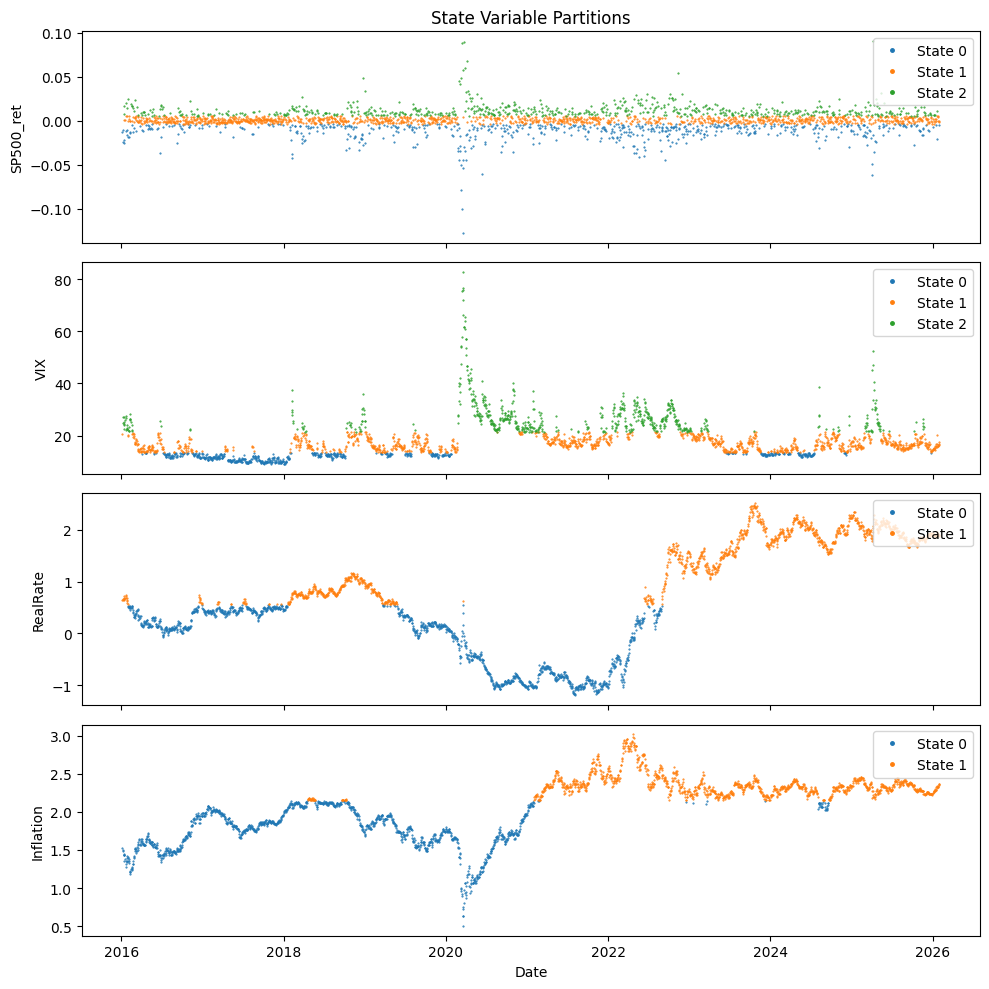

In [54]:
fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

colors = ['tab:blue', 'tab:orange', 'tab:green']

for ax, (var, n_states) in zip(axes, [('SP500_ret', 3), ('VIX', 3), ('RealRate', 2), ('Inflation', 2)]):
    series = state_vars[var].values
    regime = regimes[var.lower().replace('_ret', '').replace('rate', '_rate')].values if var != 'SP500_ret' else regimes['growth'].values
    
    for s in range(n_states):
        mask = regime == s
        masked = np.where(mask, series, np.nan)
        ax.plot(state_vars.index, masked, '.', color=colors[s], markersize=1, label=f'State {s}')
    
    ax.set_ylabel(var)
    ax.legend(loc='upper right', markerscale=5)

axes[0].set_title('State Variable Partitions')
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

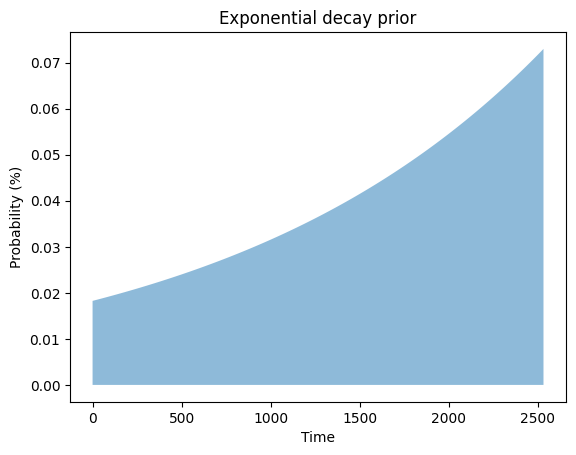

In [55]:
T = len(pnl)
p_exp = ft.exp_decay_probs(pnl, half_life=T/2)

plt.figure()
plt.fill_between(range(T), p_exp.flatten() * 100, alpha=0.5)
plt.ylabel('Probability (%)')
plt.xlabel('Time')
plt.title('Exponential decay prior')
plt.show()

In [56]:
n_states = 36
state_means = np.zeros((n_states, 4))
state_stds = np.zeros((n_states, 4))

state_var_cols = ['SP500_ret', 'VIX', 'RealRate', 'Inflation']
state_vals = state_vars[state_var_cols].values

for s in range(n_states):
    mask = regimes['state'].values == s
    if mask.sum() > 0:
        state_means[s] = np.mean(state_vals[mask], axis=0)
        state_stds[s] = np.std(state_vals[mask], axis=0)

observed_states = regimes['state'].unique()
print(f"Observed states: {len(observed_states)}")
print(f"Missing states: {set(range(n_states)) - set(observed_states)}")

Observed states: 33
Missing states: {18, 19, 20}


In [57]:
state_probs = {}

for s in observed_states:
    mu_s = state_means[s]
    sigma_s = state_stds[s]
    
    A = np.vstack((np.ones((1, T)), state_vals.T))
    b = np.vstack(([[1]], mu_s[:, np.newaxis]))
    
    G = state_vals.T ** 2
    h = (sigma_s ** 2 + mu_s ** 2)[:, np.newaxis]
    
    try:
        q = ft.entropy_pooling(p_exp, A, b, G, h)
        state_probs[s] = q.flatten()
    except:
        state_probs[s] = p_exp.flatten()
        print(f"State {s}: entropy pooling failed, using prior")

print(f"Computed probability vectors for {len(state_probs)} states")

/usr/local/lib/python3.11/dist-packages/fortitudo/tech/entropy_pooling.py:78: RuntimeWarning: overflow encountered in exp
  x = np.exp(log_x)
/usr/local/lib/python3.11/dist-packages/fortitudo/tech/entropy_pooling.py:79: RuntimeWarning: invalid value encountered in matmul
  gradient = rhs - lhs @ x
/usr/local/lib/python3.11/dist-packages/fortitudo/tech/entropy_pooling.py:80: RuntimeWarning: invalid value encountered in matmul
  objective = x.T @ (log_x - log_p) - lagrange_multipliers.T @ gradient


Computed probability vectors for 33 states


In [58]:
states_vector = regimes['state'].values
states_prob = np.zeros((T, n_states))

for s in observed_states:
    states_prob[:, s] = state_probs[s] / state_probs[s].sum()

current_state = states_vector[-1]
current_regimes = regimes.iloc[-1]

print(f"States probability matrix: {states_prob.shape}")
print(f"Current state: {current_state}")
print(f"  Growth:    {['Low', 'Mid', 'High'][current_regimes['growth']]}")
print(f"  VIX:       {['Low', 'Mid', 'High'][current_regimes['vix']]}")
print(f"  Real Rate: {['Low', 'High'][current_regimes['real_rate']]}")
print(f"  Inflation: {['Low', 'High'][current_regimes['inflation']]}")

States probability matrix: (2532, 36)
Current state: 30
  Growth:    Low
  VIX:       Mid
  Real Rate: High
  Inflation: High


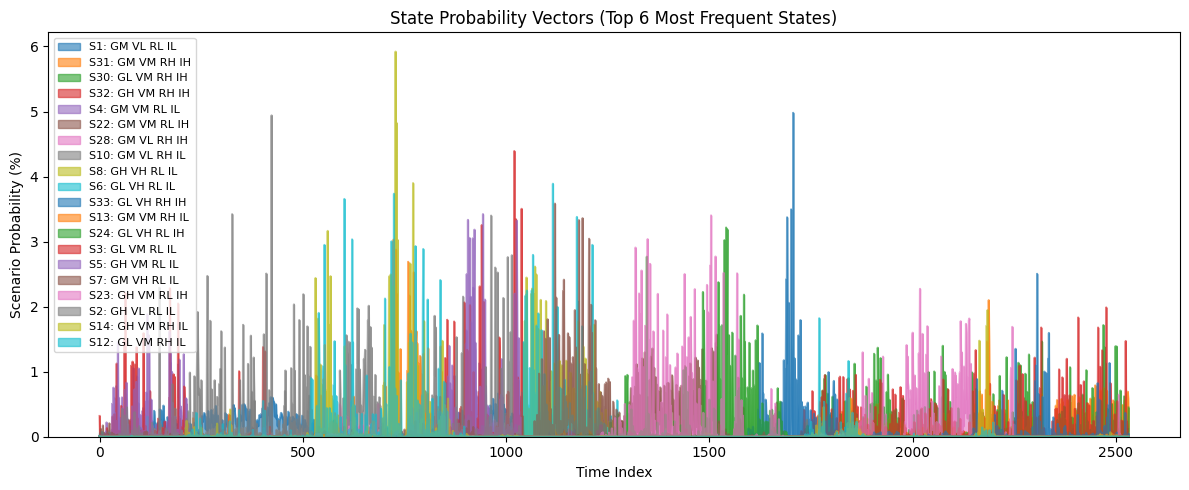

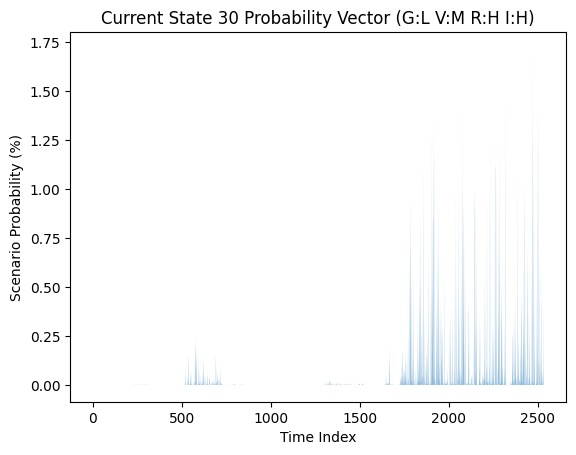

In [59]:
top_n = 20  
top_states = regimes['state'].value_counts().head(top_n).index.tolist()

prob_df = pd.DataFrame(index=range(T))
for s in top_states:
    g = s % 3
    v = (s // 3) % 3
    r = (s // 9) % 2
    i = (s // 18) % 2
    label = f"S{s}: G{['L','M','H'][g]} V{['L','M','H'][v]} R{['L','H'][r]} I{['L','H'][i]}"
    prob_df[label] = state_probs[s] / state_probs[s].sum() * 100

fig, ax = plt.subplots(figsize=(12, 5))
prob_df.plot(kind='area', stacked=False, alpha=0.6, ax=ax)
ax.set_title('State Probability Vectors (Top 6 Most Frequent States)')
ax.set_xlabel('Time Index')
ax.set_ylabel('Scenario Probability (%)')
ax.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

# Current State
current_state = states_vector[-1]
g = current_state % 3
v = (current_state // 3) % 3
r = (current_state // 9) % 2
i = (current_state // 18) % 2

plt.figure()
plt.fill_between(range(T), state_probs[current_state] / state_probs[current_state].sum() * 100, alpha=0.5)
plt.title(f'Current State {current_state} Probability Vector (G:{["L","M","H"][g]} V:{["L","M","H"][v]} R:{["L","H"][r]} I:{["L","H"][i]})')
plt.xlabel('Time Index')
plt.ylabel('Scenario Probability (%)')
plt.show()

## Risk Manager
The stacked weights are defiend in a differnet file 

In [80]:
h = 21
s = 10000
seed = 42
alpha = 0.90

equity_strategic = 300_000
equity_tactical = 150_000
risk_budget = 0.10
max_weight = 0.25

print(f"Horizon: {h}d | Scenarios: {s:,} | CVaR α: {alpha:.0%}")

Horizon: 21d | Scenarios: 10,000 | CVaR α: 90%


In [81]:
def ffr_resampling(s, h, initial_state, states_prob, states_vector, seed=None):
    if seed is not None:
        np.random.seed(seed)
    sim_idx = np.full((s, h), 0, dtype=int)
    t = np.arange(len(states_vector))
    for i in range(s):
        state = initial_state
        for j in range(h):
            sim_idx[i, j] = np.random.choice(t, p=states_prob[:, state])
            state = states_vector[sim_idx[i, j]]
    return sim_idx

def compute_cvar(returns, alpha=0.90):
    cutoff = int((1 - alpha) * len(returns))
    return -np.mean(np.sort(returns)[:cutoff])

In [82]:
strategic_weights = np.array([
    0.0426, 0.0529, 0.0398, 0.0570, 0.1556, 0.0935,
    0.0297, 0.1022, 0.0757, 0.0686, 0.0532, 0.2292
])

print("Strategic Weights:")
for name, w in zip(pnl.columns, strategic_weights):
    print(f"  {name:6s} {w*100:5.2f}%")
print(f"  Sum: {strategic_weights.sum()*100:.1f}%")

Strategic Weights:
  BTU     4.26%
  CAT     5.29%
  CBRE    3.98%
  COST    5.70%
  DECK   15.56%
  GS      9.35%
  LLY     2.97%
  NFLX   10.22%
  NRG     7.57%
  NVDA    6.86%
  SHW     5.32%
  GC=F   22.92%
  Sum: 100.0%


In [83]:
current_state = states_vector[-1]
sim_idx = ffr_resampling(s, h, current_state, states_prob, states_vector, seed=seed)

returns_h = np.exp(np.sum(pnl.values[sim_idx], axis=1)) - 1
portfolio_returns_strat = returns_h @ strategic_weights

cvar_strat = compute_cvar(portfolio_returns_strat, alpha)
leverage_strat = risk_budget / cvar_strat
max_position_strat = equity_strategic * leverage_strat

print(f"CVaR {alpha:.0%}: {cvar_strat*100:.2f}%")
print(f"Leverage: {leverage_strat:.2f}x")
print(f"Max position: ${max_position_strat:,.0f}")

CVaR 90%: 19.15%
Leverage: 0.52x
Max position: $156,638


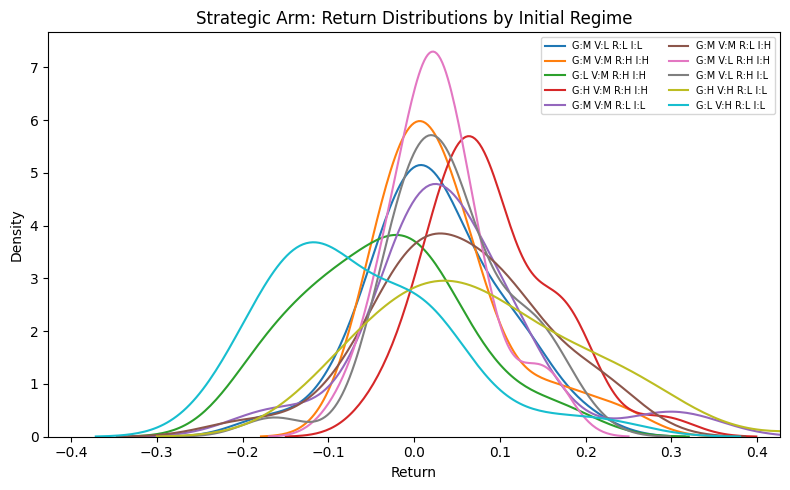

In [93]:
top_states = regimes['state'].value_counts().head(10).index.tolist()

fig, ax = plt.subplots(figsize=(8, 5))
for state in top_states:
    sim_s = ffr_resampling(s, h, state, states_prob, states_vector, seed=seed)
    ret_s = (np.exp(np.sum(pnl.values[sim_s], axis=1)) - 1) @ strategic_weights
    g = state % 3
    v = (state // 3) % 3
    r = (state // 9) % 2
    inf = (state // 18) % 2
    label = f'G:{["L","M","H"][g]} V:{["L","M","H"][v]} R:{["L","H"][r]} I:{["L","H"][inf]}'
    sns.kdeplot(ret_s, label=label, ax=ax)

xlim = abs(ax.get_xlim()[0])
ax.set_xlim(-xlim, xlim)
ax.set_title('Strategic Arm: Return Distributions by Initial Regime')
ax.set_xlabel('Return')
ax.legend(fontsize=7, ncol=2)
plt.tight_layout()
plt.show()

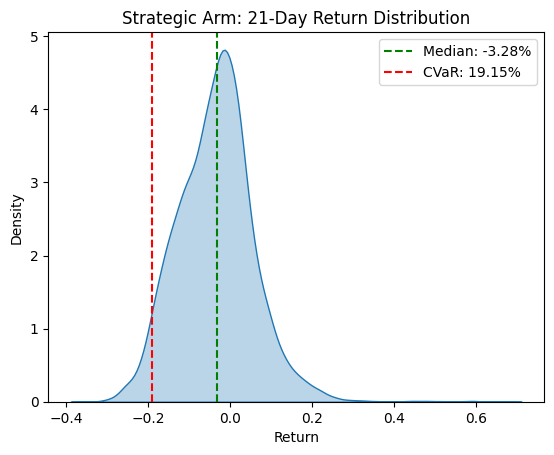

In [77]:
fig, ax = plt.subplots()
sns.kdeplot(portfolio_returns_strat, fill=True, alpha=0.3)
ax.axvline(np.median(portfolio_returns_strat), color='green', ls='--', label=f'Median: {np.median(portfolio_returns_strat)*100:+.2f}%')
ax.axvline(-cvar_strat, color='red', ls='--', label=f'CVaR: {cvar_strat*100:.2f}%')
ax.set_title(f'Strategic Arm: {h}-Day Return Distribution')
ax.set_xlabel('Return')
ax.legend()
plt.show()

## Portfolio Optimisation for Posterior

In [94]:
returns_h_assets = np.exp(np.sum(pnl.values[sim_idx], axis=1)) - 1

i_assets = pnl.shape[1]
g_opt = np.vstack([np.eye(i_assets), -np.eye(i_assets)])
h_opt = np.hstack([max_weight * np.ones(i_assets), max_weight * np.ones(i_assets)])

cvar_optimizer = ft.MeanCVaR(returns_h_assets, g_opt, h_opt, alpha=alpha)
return_target = returns_h_assets.mean(axis=0).mean()
tactical_weights = np.array(cvar_optimizer.efficient_portfolio(return_target)).flatten()

print("Tactical Weights:")
for name, w in zip(pnl.columns, tactical_weights):
    print(f"  {name:6s} {w*100:5.2f}%")
print(f"  Sum: {tactical_weights.sum()*100:.1f}%")

Tactical Weights:
  BTU    -0.26%
  CAT     3.02%
  CBRE   -13.86%
  COST   25.00%
  DECK    5.62%
  GS     13.18%
  LLY    25.00%
  NFLX    4.09%
  NRG    11.76%
  NVDA   -23.56%
  SHW    25.00%
  GC=F   25.00%
  Sum: 100.0%


In [95]:
portfolio_returns_tact = returns_h_assets @ tactical_weights

cvar_tact = compute_cvar(portfolio_returns_tact, alpha)
leverage_tact = risk_budget / cvar_tact
max_position_tact = equity_tactical * leverage_tact

print(f"CVaR {alpha:.0%}: {cvar_tact*100:.2f}%")
print(f"Leverage: {leverage_tact:.2f}x")
print(f"Max position: ${max_position_tact:,.0f}")

CVaR 90%: 9.87%
Leverage: 1.01x
Max position: $151,938


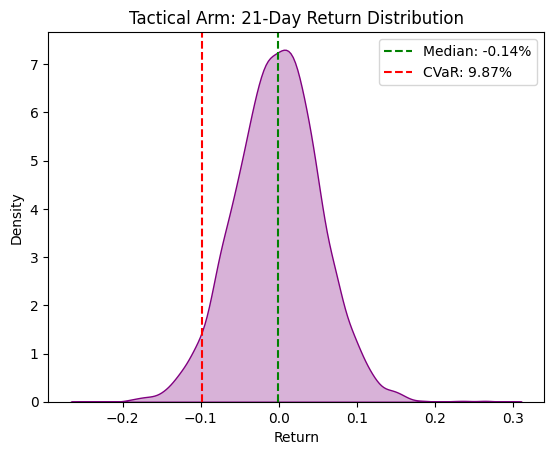

In [96]:
fig, ax = plt.subplots()
sns.kdeplot(portfolio_returns_tact, fill=True, alpha=0.3, color='purple')
ax.axvline(np.median(portfolio_returns_tact), color='green', ls='--', label=f'Median: {np.median(portfolio_returns_tact)*100:+.2f}%')
ax.axvline(-cvar_tact, color='red', ls='--', label=f'CVaR: {cvar_tact*100:.2f}%')
ax.set_title(f'Tactical Arm: {h}-Day Return Distribution')
ax.set_xlabel('Return')
ax.legend()
plt.show()